<a href="https://colab.research.google.com/github/mong-head/learn_colab/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from pandas import Series, DataFrame

# * data 처리

Load TADPOLE* dataset (csv file) from Google Drive
-------------------------------------------------------
*The Alzheimer's Disease Prediction Of Longitudinal Evolution
(https://tadpole.grand-challenge.org/)

### -Subjects: 1707 (1363 Train (80%) + 344 Test (20%))
### -Features: 72
*   2 demographic feature: MMSE, ADAS13
*   70 mean values of cortical thickness

데이터 불러오기

In [ ]:

csv_file_train = '/content/drive/Shared drives/learn-colab/train_data/Train_data_reupdated.csv'  # Set your path
train_data = pd.read_csv(csv_file_train)
train_data

# DXCHANGE: clinical label (1-CN, 2-MCI, 3-AD)

,RID,DXCHANGE,AGE,MMSE,ADAS13,ST102TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST105TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST106TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST107TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST108TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST109TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST110TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST111TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST113TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST114TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST115TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST116TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST117TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST118TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST119TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST121TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST129TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST130TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST13TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST14TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST15TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST23TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST24TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST25TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST26TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST31TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST32TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST34TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST35TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST36TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST38TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST39TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST40TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST43TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST44TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST45TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST46TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST47TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST48TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST49TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST50TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST51TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST52TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST54TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST55TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST56TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST57TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST58TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST59TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST60TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST62TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST72TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST73TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST74TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST82TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
0,4084,1,68.4,30,10.00,2.700,2.635,2.613,2.904,2.311,1.647,2.139,2.652,2.604,2.480,3.095,2.144,2.792,2.207,2.903,2.617,4.117,2.701,,3.127,3.051,2.305,2.872,2.732,2.026,3.756,2.813,2.762,2.556,2.916,2.695,2.259,2.690,2.017,2.421,2.949,2.570,2.370,2.674,3.004,2.369,1.599,2.208,2.650,2.739,2.544,3.018,2.377,2.880,2.322,2.657,2.489,3.620,2.711,,2.593,2.792,2.660,1.993,3.734,2.390,2.817,2.471,2.990,2.667,2.490,2.523,2.254,2.171,2.862
1,2196,2,68.2,30,13.00,2.453,2.992,2.470,2.965,2.438,1.584,1.910,2.900,2.451,2.335,2.771,2.354,2.712,2.001,2.729,2.363,3.613,2.475,,3.196,3.334,2.343,2.729,2.627,1.742,3.383,2.647,2.758,2.394,2.634,2.334,2.241,2.824,1.865,2.383,2.866,2.334,2.793,2.413,2.874,2.316,1.478,1.909,2.780,2.589,2.133,3.036,2.329,2.687,2.070,2.783,2.594,3.405,2.367,,2.582,2.977,2.489,1.868,3.220,2.683,2.569,2.372,2.854,2.867,2.233,2.793,1.987,2.428,2.943
2,657,1,77.7,29,15.33,2.249,2.296,2.315,2.681,2.420,1.386,1.830,2.466,2.3

train_data.info()로 확인하니, 빠져있는 데이터도 있고(예측값인 ADAS13, cortical값 중에 1개), 실제로는 NaN값이지만 ' '로 채워진 데이터가 2개가 있었다.

' '로 채워져 있어 object인 두 cortical값
*   ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
*   ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16

데이터 처리 순서
1. object 처리 : space to NaN
2. imputer : median으로 빠져있는 값들 채우기
3. feature scaling - RobustScaler : cortical, age 값의 범위를 같게 맞춘다.

** StandardScaler안쓰고 RobustScaler하는 이유 : 실제로 이게 더 나았음- outlier제거가 되기때문임

2,3을 pipeline으로 하고, 2 전에 AD_tr(cortical값들, age),y(reg/cls)로 나누고,

AD_tr만 pipeline해서 X로 만들고, y는 imputer만 한다.


1) object처리
---

In [ ]:
#2개의 cortical feature가 float이 아니라 object이고, ' '로 채워져있다.
ob1 = train_data["ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"]
ob2 = train_data["ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"]
print(len(train_data[ob1.isnull()]), ob1.dtypes)
print(len(train_data[ob2.isnull()]),ob2.dtypes)

0 object
0 object


In [ ]:
#그냥 ' '로 뜬다.
train_data["ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"][0]

' '

In [ ]:
def object_to_float(o): #o = train_data["~~"] 형태
  for i in range(1363):
    if o[i] == ' ':
      o[i] = np.nan #nan으로 채움

In [ ]:
object_to_float(ob1)
object_to_float(ob2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
print(len(train_data[ob1.isnull()]), ob1.dtypes)
print(len(train_data[ob2.isnull()]),ob2.dtypes)

724 object
724 object


**train, test set나누기
---
AD_train, AD_test = 

In [ ]:
#RID는 버림
train_data = train_data.drop("RID",axis=1)

** trian, test set 나누기
---
train set에서 model들의 train loss와 validation loss등을 보며 model을 결정하고

test set에서 마지막으로 검사해보았을 때에도 최적의 모델이라면 

그 모델을 선택하고, 마지막에는 train, test set 나누기 전의 X로 최종으로 선택했던 모델로 마지막 training시킨다.

In [ ]:
from sklearn.model_selection import train_test_split

AD_train, AD_test = train_test_split(train_data,test_size=0.2,random_state= 42)

** AD_tr, y나누고, y에는 imputer
---

RID는 버린다.

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [ ]:
##input 해당
X_prepipeline = train_data.drop("MMSE",axis = 1).drop("ADAS13",axis = 1).drop("DXCHANGE",axis = 1)
X_train_prepipeline = AD_train.drop("MMSE",axis = 1).drop("ADAS13",axis = 1).drop("DXCHANGE",axis = 1)
X_test_prepipeline = AD_test.drop("MMSE",axis = 1).drop("ADAS13",axis = 1).drop("DXCHANGE",axis = 1)

#classification input
X_plus_prepipeline = train_data.drop("DXCHANGE",axis = 1)
X_plus_train_prepipeline = AD_train.drop("DXCHANGE",axis = 1)
X_plus_test_prepipeline = AD_test.drop("DXCHANGE",axis = 1)

##output 해당
AD_label_reg = DataFrame({"MMSE":train_data["MMSE"].copy(),
                         "ADAS13":train_data["ADAS13"].copy()})
AD_label_reg_tr = DataFrame({"MMSE":AD_train["MMSE"].copy(),
                         "ADAS13":AD_train["ADAS13"].copy()})
AD_label_reg_test = DataFrame({"MMSE":AD_test["MMSE"].copy(),
                         "ADAS13":AD_test["ADAS13"].copy()})

imputer.fit(AD_label_reg)
temp = imputer.transform(AD_label_reg)
y_reg = pd.DataFrame(temp, columns=AD_label_reg.columns,
                             index=AD_label_reg.index)

imputer.fit(AD_label_reg_tr)
temp = imputer.transform(AD_label_reg_tr)
y_reg_train = pd.DataFrame(temp, columns=AD_label_reg_tr.columns,
                             index=AD_label_reg_tr.index)
imputer.fit(AD_label_reg_test)
temp = imputer.transform(AD_label_reg_test)
y_reg_test = pd.DataFrame(temp, columns=AD_label_reg_test.columns,
                             index=AD_label_reg_test.index)

y_mmse =  DataFrame({"MMSE":y_reg["MMSE"].copy()})
y_mmse_train = DataFrame({"MMSE":y_reg_train["MMSE"].copy()})
y_mmse_test = DataFrame({"MMSE":y_reg_test["MMSE"].copy()})

y_ada =  DataFrame({"ADAS13":y_reg["ADAS13"].copy()})
y_ada_train = DataFrame({"ADAS13":y_reg_train["ADAS13"].copy()})
y_ada_test = DataFrame({"ADAS13":y_reg_test["ADAS13"].copy()})

y_cls =  DataFrame({"DXCHANGE":train_data["DXCHANGE"]})
y_cls_train = DataFrame({"DXCHANGE":AD_train["DXCHANGE"]})
y_cls_test = DataFrame({"DXCHANGE":AD_test["DXCHANGE"]})

incomplete_rows_before = AD_label_reg_tr[AD_label_reg_tr.isnull().any(axis=1)]#.head()
incomplete_rows_after = y_reg_train[y_reg_train.isnull().any(axis=1)]
print("1. before imputer:\n", incomplete_rows_before)
print("\n2. after imputer : \n", incomplete_rows_after)

1. before imputer:
       MMSE  ADAS13
522     23     NaN
25      21     NaN
1311    18     NaN
999     20     NaN
426     25     NaN
946     29     NaN
431     22     NaN

2. after imputer : 
 Empty DataFrame
Columns: [MMSE, ADAS13]
Index: []


2) pipeline : imputer,RobustScaler
---
* imputer - 빈데이터 채우기
* RobustScaler - 값 범위 같게 만들기, Standard보다는 outlier다루는데 더 괜찮을 거 같아서 이것을 썼다.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [ ]:
#빈데이터 모두 보기
incomplete_rows = X_prepipeline[X_prepipeline.isnull().any(axis=1)]#.head()
print("빈데이터 개수: ",len(incomplete_rows))

빈데이터 개수:  724


In [ ]:
data_pipeline = Pipeline([
                     ('imputer',SimpleImputer(strategy="median")),
                     ('rb_scaler',RobustScaler()),
])

In [ ]:
X = data_pipeline.fit_transform(X_prepipeline)
X_train = data_pipeline.fit_transform(X_train_prepipeline)
X_test = data_pipeline.fit_transform(X_test_prepipeline)

X_plus = data_pipeline.fit_transform(X_plus_prepipeline)
X_plus_train = data_pipeline.fit_transform(X_plus_train_prepipeline)
X_plus_test = data_pipeline.fit_transform(X_plus_test_prepipeline)

# * CNN 


keras 1d
https://buomsoo-kim.github.io/keras/2018/05/16/Easy-deep-learning-with-Keras-12.md/

pytorch 주가
https://direction-f.tistory.com/19

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from pandas import Series, DataFrame

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

import tensorflow as tf
from tensorflow import keras

In [ ]:
embedding_dimension = 100

In [ ]:
X_train.shape

(1090, 71)

In [ ]:
X_plus_train = X_plus_train.reshape(X_plus_train.shape[0], X_plus_train.shape[1], 1)
print(X_plus_train.shape)

(1090, 73, 1)


In [ ]:
y_cls_train.shape

(1090, 1)

In [ ]:
#y_cls_train = tf.keras.utils.to_categorical(y_cls_train.values - 1)
y_cls_test = tf.keras.utils.to_categorical(y_cls_test.values - 1)

In [ ]:
y_cls_train.shape

(1090, 3)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Embedding, Flatten,AveragePooling1D, GlobalAveragePooling1D
from keras import optimizers

def cnn():
    dropout=0.5
    model = Sequential()
    model.add(Conv1D(100, 10, activation="relu", input_shape=(73, 1)))
    #model.add(Conv1D(100, 10, activation="selu", input_shape=(73, 1)))
    model.add(MaxPooling1D())
    model.add(Conv1D(50, 3, activation="relu", input_shape=(73, 1)))
    model.add(MaxPooling1D())

    model.add(Flatten())
    
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(25, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr = 0.001)

    model.compile(loss='categorical_crossentropy', optimizer=adam , metrics=['accuracy'])

    return model

model = cnn()

In [ ]:
%%time
history = model.fit(X_plus_train, y_cls_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose = 0)

CPU times: user 7.82 s, sys: 903 ms, total: 8.72 s
Wall time: 7.24 s


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


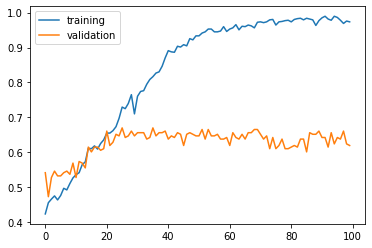

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

In [ ]:
results = model.evaluate(X_test, y_reg_test)

In [ ]:
print('Test accuracy: ', results[1])